<a href="https://colab.research.google.com/github/julesripoll/crypto-trading-bot/blob/jules_branch/bot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tf_agents
!pip install fastquant

In [2]:
import tf_agents
from tf_agents.environments import py_environment
from tf_agents.specs import array_spec
from tf_agents.trajectories import time_step as ts


class TradingEnvTrain(py_environment.PyEnvironment):

    def __init__(self, df, window_size, tc, balance=1000):
        self._action_spec= array_spec.BoundedArraySpec(shape=(), dtype=int, minimum=0, maximum=2)
        self._observation_spec= array_spec.BoundedArraySpec(shape=(5,df.shape[1]), dtype=float, minimum=0)
        self._episode_ended=False
        self.initial_balance=balance 
        self.current_balance=balance
        self.train_df=df
        self.train_index=window_size
        self.tc=tc
        self.window_size=window_size
        self.state= df[:][self.train_index-window_size:self.train_index]
        self.positioned=False
        self.buying_price=0
        self._episode_ended=False

    def action_spec(self):
        return self._action_spec

    def observation_spec(self):
        return self._observation_spec

    def _reset(self):
        self._episode_ended=False
        self.train_index=self.window_size
        self.current_balance=self.initial_balance
        self.state= self.train_df[:][self.train_index-self.window_size:self.train_index]
        step=ts.restart(observation=self.state)
        print('reset has been hit',step.step_type)
        return step

    def reward(self, ind, buying_price):
        return self.train_df['close'][ind]-buying_price-self.tc
    
    def _step(self, action):
        """
        step retourne 4 valeurs : 
        -observation : une observation de l'environnement, ici une séquence de prix. object
        -reward : une récompense, définie ci dessous, dépendant de l'action effectuée. float
        -done : boolean indiquant si on doit reset l'env, terminant donc l'episode. boolean
        -info : information de notre choix. dict 

        note : les actions possibles dépendent de si on est positionné ou non, et là c'est pas pris en compte.
        """
        if self._episode_ended :
          return self.reset()
        rwd=0
        current_price=self.train_df['close'][self.train_index]
        if action==0 : #buy
            rwd=0
            self.buying_price=current_price
            self.current_balance-=current_price
            self.positioned=True
        elif action==1: #do nothing
            rwd=0
        elif action==2: #sell
            self.positioned=False
            rwd=self.reward(self.train_index,self.buying_price)
            self.current_balance+=current_price

        self.train_index+=1
        self.state=self.train_df[:][self.train_index-self.window_size:self.train_index]

        if (self.train_index==self.len_train) or self.current_balance<self.initial_balance*0.6:
            self._episode_ended=True
            self.train_index=self.window_size
            step=ts.termination(reward=rwd, observation=self.state)
            print('episode terminated',step.step_type) #si c'est bien 2 c'est ISLAST
            return step
            """
            ts.termination retourne un TimeStep. si termination à priori ça renvoie un done = true.
            A verifier dans la cellule de validation. 
            Ici la condition d'arrêt c'est d'avoir perdu 10% de l'investissement initial ou d'avoir fini le training set
            """
        else:
            step=ts.transition(reward=rwd, observation=self.state)
            print('transitioning,',step.step_type) 
            return step  #s'il ne s'agit pas de la fin d'un épisode. Step type induit par transition

    def _render(self):
        pass





In [3]:
#from trade import TradingEnv
from tf_agents.agents import DqnAgent
import pandas as pd
from tf_agents.environments import tf_py_environment
import tensorflow as tf
from tf_agents.utils import common
from tf_agents.specs import tensor_spec
from tf_agents.networks.q_rnn_network import QRnnNetwork
from tf_agents.drivers import py_driver
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers.tf_uniform_replay_buffer import  TFUniformReplayBuffer
from tf_agents.drivers.dynamic_step_driver import DynamicStepDriver
from tf_agents.drivers.dynamic_episode_driver import DynamicEpisodeDriver
from numpy import random
from tf_agents.metrics import tf_metrics
import numpy as np
import tf_agents.trajectories as trajectory
import fastquant as fq
import datetime as dt
import matplotlib.pyplot as plt

In [4]:
#cellule d'import des données
start='2021-01-01'
end='2022-01-01'

eth=pd.DataFrame(fq.get_crypto_data('ETH/USDT',start,end))
eth.head()

,open,high,low,close,volume
dt,,,,,
2021-01-01,736.42,749.00,714.29,728.91,6.751141e+05
2021-01-02,728.91,787.69,714.91,774.56,1.352619e+06
2021-01-03,774.44,1011.07,768.71,978.28,2.813604e+06
2021-01-04,978.33,1162.97,890.00,1041.43,4.245011e+06
2021-01-05,1041.45,1134.60,974.45,1099.56,2.706996e+06


In [5]:
eth[:][:3]

,open,high,low,close,volume
dt,,,,,
2021-01-01,736.42,749.00,714.29,728.91,6.751141e+05
2021-01-02,728.91,787.69,714.91,774.56,1.352619e+06
2021-01-03,774.44,1011.07,768.71,978.28,2.813604e+06


In [6]:
#hyperparamètres
initial_collect_steps = 100
batch_size=32
max_length=100 #pareil que initial collect steps?

In [7]:
#init de l'environnement
train_py_env=TradingEnvTrain(eth[:300], window_size=5,tc=10)
print(train_py_env.state)
train_env = tf_py_environment.TFPyEnvironment(train_py_env)


               open     high     low    close        volume
dt                                                         
2021-01-01   736.42   749.00  714.29   728.91  6.751141e+05
2021-01-02   728.91   787.69  714.91   774.56  1.352619e+06
2021-01-03   774.44  1011.07  768.71   978.28  2.813604e+06
2021-01-04   978.33  1162.97  890.00  1041.43  4.245011e+06
2021-01-05  1041.45  1134.60  974.45  1099.56  2.706996e+06


In [8]:
rewards = []
steps = []
num_episodes = 5

for i in range(num_episodes):
  print('episode',i)
  time_step = train_env.reset()
  episode_reward = 0
  episode_steps = 0
  while not time_step.is_last():
    action=random.randint(0,3)
    time_step = train_env.step(action)
    episode_steps += 1
    episode_reward += time_step.reward.numpy()
  print('episode steps', episode_steps)
  print('#########################################################################')
  rewards.append(episode_reward)
  steps.append(episode_steps)

num_steps = np.sum(steps)
avg_length = np.mean(steps)
avg_reward = np.mean(rewards)

print('num_episodes:', num_episodes, 'num_steps:', num_steps)
print('avg_length', avg_length, 'avg_reward:', avg_reward)

episode 0
reset has been hit 0
transitioning, 1
episode terminated 2
episode steps 2
#########################################################################
episode 1
reset has been hit 0
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
episode terminated 2
episode steps 13
#########################################################################
episode 2
reset has been hit 0
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
tran

In [9]:
#init du réseau
rnn_net=QRnnNetwork(
    input_tensor_spec=train_env.observation_spec(),
    action_spec=train_env.action_spec(),
    lstm_size=(40,),
    output_fc_layer_params=(20,)
    )

In [10]:
#init de l'agent
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)
global_step=tf.Variable(0)

agent=DqnAgent(
    time_step_spec=train_env.time_step_spec(),
    action_spec=train_env.action_spec(),
    q_network=rnn_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=global_step
)

In [11]:
rdm_policy = random_tf_policy.RandomTFPolicy(action_spec=train_env.action_spec(),
                                            time_step_spec=train_env.time_step_spec())

Ctrl+M M pour cellule en texte

en dessous on a plusieurs essais de driver et replay buffer. Voir la doc tensorflow (notebooks dqn agent with tf-agents, et replay buffers).

In [12]:
agent.collect_data_spec #la trajectoire collectée par l'agent

Trajectory(
{'action': BoundedTensorSpec(shape=(), dtype=tf.int64, name=None, minimum=array(0), maximum=array(2)),
 'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'next_step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type'),
 'observation': BoundedTensorSpec(shape=(5, 5), dtype=tf.float64, name=None, minimum=array(0.), maximum=array(1.79769313e+308)),
 'policy_info': (),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')})

In [13]:
train_env.batch_size

1

In [14]:
replay_buffer = TFUniformReplayBuffer(
    agent.collect_data_spec,
    batch_size=1,
    max_length=1000
    )

In [20]:
env_steps=tf_metrics.EnvironmentSteps()
observers=[replay_buffer.add_batch,env_steps]
driver=DynamicEpisodeDriver(
    train_env,
    rdm_policy,
    observers,
    num_episodes=10
)

#final_time_step, policy_state = driver.run()

#print('final_time_step', final_time_step)
#print('Number of Steps: ', env_steps.result().numpy())

In [16]:
training_set=replay_buffer.as_dataset(
    sample_batch_size=32,
    num_steps=40
)

Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


In [21]:
iterator=iter(training_set)
print(iterator)

In [18]:
#iterator.next() #on voit que chaque itéré du dataset correspond à un batch.

Ou alors on peut essayer de tout faire d'un coup

In [22]:
try:
  %%time
except:
  pass
num_iter=100

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step.
agent.train_step_counter.assign(0) #je crois que ça correspond au nb d'epoch en tous cas c'est quand ce truc atteint num_iter qu'on arrête l'entrainement

# Reset the environment.
time_step = train_env.reset()
losses=[]

for _ in range(num_iter):
  print('hola',agent.train_step_counter)
  # Collect a few steps and save to the replay buffer.
  time_step, _ = driver.run(time_step) #c'est ce truc là en fait qui dure 30 episodes comme définit précédemment

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience).loss
  losses.append(train_loss)
  step = agent.train_step_counter.numpy()

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
tran

In [23]:
print(experience)

Trajectory(
{'action': <tf.Tensor: shape=(32, 40), dtype=int64, numpy=
array([[2, 1, 0, ..., 1, 1, 1],
       [1, 2, 0, ..., 2, 0, 1],
       [1, 0, 1, ..., 1, 1, 1],
       ...,
       [2, 1, 2, ..., 1, 1, 1],
       [0, 2, 2, ..., 0, 1, 2],
       [1, 1, 1, ..., 0, 0, 0]])>,
 'discount': <tf.Tensor: shape=(32, 40), dtype=float32, numpy=
array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 0., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(32, 40), dtype=int32, numpy=
array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 2, 0, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=int32)>,
 'observation': <tf.Tensor: shape=(32, 40, 5, 5), dtype=float64, numpy=
array([[[[1.76613000e+03, 1.94430000e+03, 

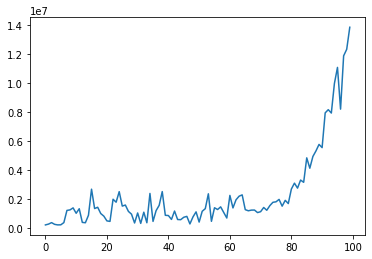

In [24]:
plt.plot(losses)